# 필수 라이브러리

In [15]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

### API 설정

In [16]:
# API Football 설정
API_KEY = "6fa7c32f63865084b3ad7130cefea43b"
API_HOST = "v3.football.api-sports.io"
BASE_URL = "https://v3.football.api-sports.io/"

headers = {
    "x-apisports-key": API_KEY,
    "x-apisports-host": API_HOST
}

## 데이터 가져오기 

In [17]:
def get_league_standings(league_id, season):
    """리그 순위 데이터를 가져옴"""
    url = f"{BASE_URL}standings"
    params = {"league": league_id, "season": season}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['response'][0]['league']['standings'][0] if data['response'] else None
    return None

def get_top_scorers(league_id, season):
    """리그 득점 순위 데이터를 가져옴"""
    url = f"{BASE_URL}players/topscorers"
    params = {"league": league_id, "season": season}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['response'] if data['response'] else None
    return None

def get_team_fixtures(team_id, season):
    """팀의 경기 결과를 가져옴"""
    url = f"{BASE_URL}fixtures"
    params = {"team": team_id, "season": season, "last": 50}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['response'] if data['response'] else None
    return None

# 데이터셋 파싱

In [18]:
def parse_standings(standings_data):
    """순위 데이터를 DataFrame으로 변환"""
    standings = []
    for team in standings_data:
        team_info = {
            'rank': team['rank'],
            'team': team['team']['name'],
            'points': team['points'],
            'played': team['all']['played'],
            'won': team['all']['win'],
            'drawn': team['all']['draw'],
            'lost': team['all']['lose'],
            'goals_for': team['all']['goals']['for'],
            'goals_against': team['all']['goals']['against']
        }
        standings.append(team_info)
    return pd.DataFrame(standings)

def parse_top_scorers(scorers_data):
    """득점 순위 데이터를 DataFrame으로 변환"""
    scorers = []
    for player in scorers_data:
        player_info = {
            'name': player['player']['name'],
            'team': player['statistics'][0]['team']['name'],
            'goals': player['statistics'][0]['goals']['total'],
            'assists': player['statistics'][0]['goals']['assists'] or 0,
            'played': player['statistics'][0]['games']['appearences']
        }
        scorers.append(player_info)
    return pd.DataFrame(scorers)

def prepare_match_data(fixtures_data, team_id):
    """경기 데이터를 모델링에 적합한 형태로 변환"""
    matches = []
    for fixture in fixtures_data:
        home_team = fixture['teams']['home']
        away_team = fixture['teams']['away']
        is_home = home_team['id'] == team_id
        opponent_id = away_team['id'] if is_home else home_team['id']
        
        # 승리 여부에 대해 None 체크를 추가
        home_winner = fixture['teams']['home']['winner']
        away_winner = fixture['teams']['away']['winner']
        win = int(home_winner if is_home else away_winner) if home_winner is not None and away_winner is not None else 0

        match_info = {
            'team_id': team_id,
            'opponent_id': opponent_id,
            'is_home': int(is_home),
            'team_goals': fixture['goals']['home'] if is_home else fixture['goals']['away'],
            'opponent_goals': fixture['goals']['away'] if is_home else fixture['goals']['home'],
            'win': win
        }
        matches.append(match_info)
    return pd.DataFrame(matches)


In [45]:
def get_and_prepare_match_data(team_id, season):
    fixtures_data = get_team_fixtures(team_id, season)
    if fixtures_data:
        return prepare_match_data(fixtures_data, team_id)
    else:
        print("Failed to fetch fixtures data.")
        return None
    # 맨체스터 유나이티드의 팀 ID 및 시즌 정보 설정
team_id = 33  # 맨체스터 유나이티드의 팀 ID (API 문서 또는 데이터를 통해 확인)
season = 2023  # 예시로 2023 시즌
df_matches = get_and_prepare_match_data(team_id, season)
if df_matches is not None:
    print(df_matches)
else:
    print("No match data available to display.")

    team_id  opponent_id  is_home  team_goals  opponent_goals  win
0        33           50        0           2               1    1
1        33           51        0           2               0    1
2        33           34        1           3               2    1
3        33           42        1           0               1    0
4        33           52        0           0               4    0
5        33           44        1           1               1    0
6        33           62        1           4               2    1
7        33         1346        0           3               3    1
8        33           35        0           2               2    0
9        33           40        1           2               2    0
10       33           49        0           3               4    0
11       33           55        0           1               1    0
12       33           40        1           4               3    1
13       33           45        1           2               0 

In [46]:
# 데이터를 로드하고 출력하는 코드
league_id = 39  # 예시: 프리미어 리그
season = 2023
team_id = 33   # 예시: 맨유

# 리그 순위 데이터
standings_data = get_league_standings(league_id, season)
if standings_data:
    df_standings = parse_standings(standings_data)
    print("League Standings:")
    print(df_standings)
else:
    print("Failed to fetch standings data.")

# 득점 순위 데이터
top_scorers_data = get_top_scorers(league_id, season)
if top_scorers_data:
    df_top_scorers = parse_top_scorers(top_scorers_data)
    print("\nTop Scorers:")
    print(df_top_scorers)
else:
    print("Failed to fetch top scorers data.")

# 팀 경기 결과 데이터 로드 및 출력
fixtures_data = get_team_fixtures(team_id, season)
if fixtures_data:
    df_fixtures = prepare_match_data(fixtures_data, team_id)
    print("\nRecent Fixtures:")
    print(df_fixtures)
else:
    print("Failed to fetch fixtures data.")



League Standings:
    rank               team  points  played  won  drawn  lost  goals_for  \
0      1    Manchester City      91      38   28      7     3         96   
1      2            Arsenal      89      38   28      5     5         91   
2      3          Liverpool      82      38   24     10     4         86   
3      4        Aston Villa      68      38   20      8    10         76   
4      5          Tottenham      66      38   20      6    12         74   
5      6            Chelsea      63      38   18      9    11         77   
6      7          Newcastle      60      38   18      6    14         85   
7      8  Manchester United      60      38   18      6    14         57   
8      9           West Ham      52      38   14     10    14         60   
9     10     Crystal Palace      49      38   13     10    15         57   
10    11           Brighton      48      38   12     12    14         55   
11    12        Bournemouth      48      38   13      9    16         

# EDA

In [47]:
def analyze_standings(standings_df):
    """순위 데이터 분석 및 시각화"""
    plt.figure(figsize=(12, 6))
    sns.barplot(x='team', y='points', data=standings_df.head(10))
    plt.title('Top 10 Teams by Points')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(standings_df[['team', 'points', 'played', 'won', 'drawn', 'lost']].head(10))

def analyze_top_scorers(scorers_df):
    """득점 순위 데이터 분석 및 시각화"""
    plt.figure(figsize=(12, 6))
    sns.barplot(x='name', y='goals', data=scorers_df.head(10))
    plt.title('Top 10 Scorers')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(scorers_df[['name', 'team', 'goals', 'assists', 'played']].head(10))


In [39]:
league_id = 39  # Premier League
season = 2023

# 순위 데이터 가져오기
standings_data = get_league_standings(league_id, season)
if standings_data:
    standings_df = parse_standings(standings_data)
    print("순위 데이터 가져오기 성공")
else:
    print("순위 데이터 가져오기 실패")

# 득점 순위 데이터 가져오기
scorers_data = get_top_scorers(league_id, season)
if scorers_data:
    scorers_df = parse_top_scorers(scorers_data)
    print("득점 순위 데이터 가져오기 성공")
else:
    print("득점 순위 데이터 가져오기 실패")

순위 데이터 가져오기 성공
득점 순위 데이터 가져오기 성공


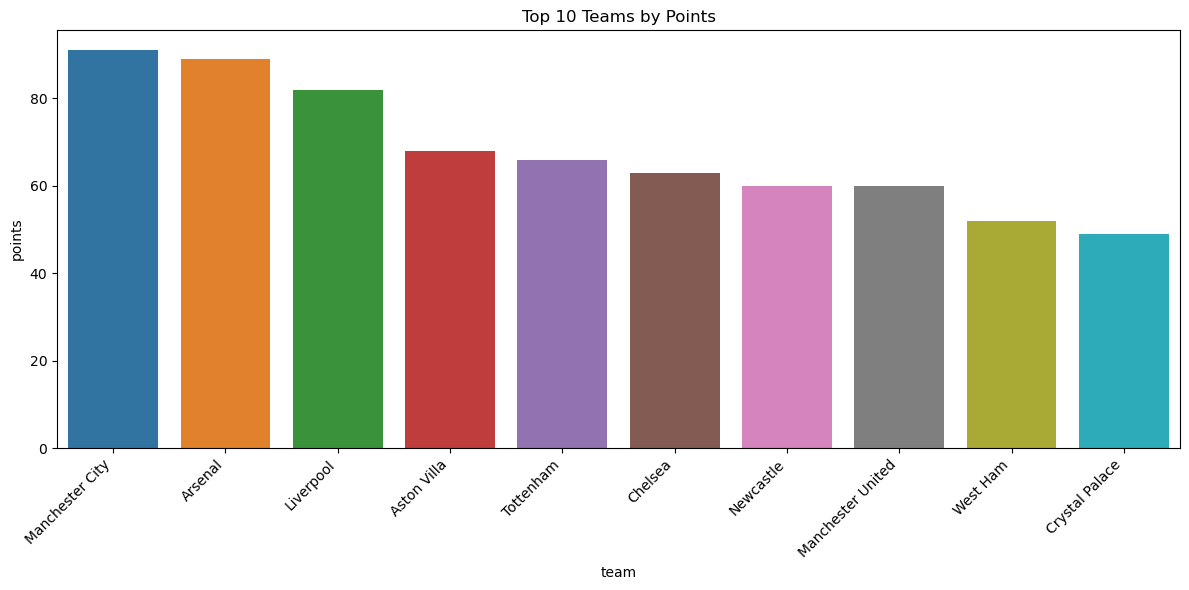

                team  points  played  won  drawn  lost
0    Manchester City      91      38   28      7     3
1            Arsenal      89      38   28      5     5
2          Liverpool      82      38   24     10     4
3        Aston Villa      68      38   20      8    10
4          Tottenham      66      38   20      6    12
5            Chelsea      63      38   18      9    11
6          Newcastle      60      38   18      6    14
7  Manchester United      60      38   18      6    14
8           West Ham      52      38   14     10    14
9     Crystal Palace      49      38   13     10    15


In [31]:
if 'standings_df' in locals():
    analyze_standings(standings_df)
else:
    print("순위 데이터가 없습니다.")

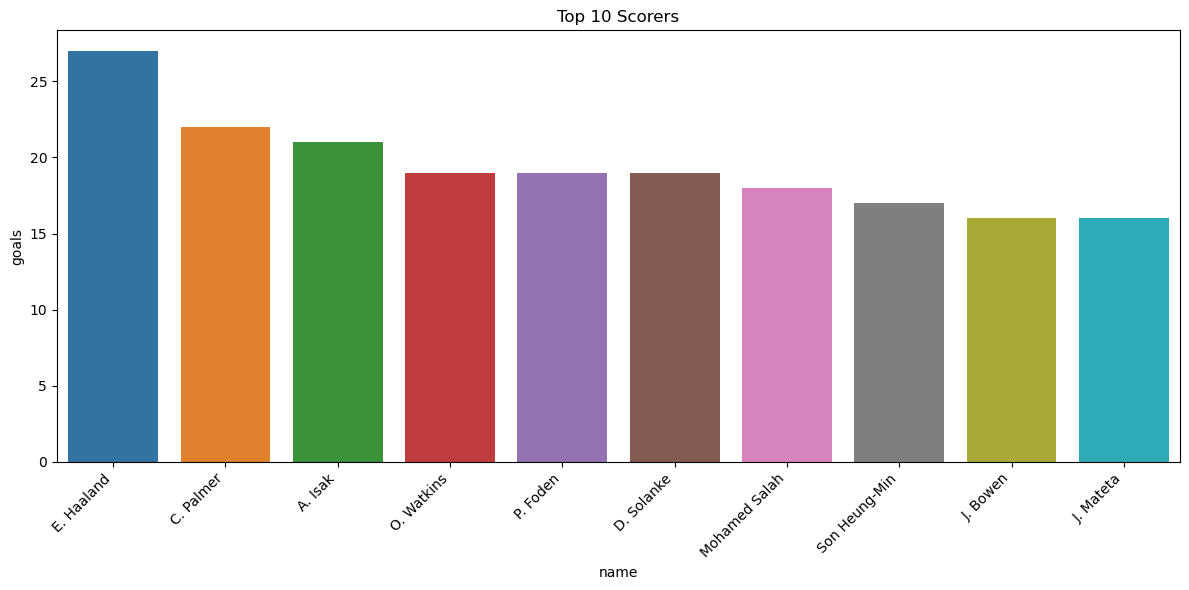

            name             team  goals  assists  played
0     E. Haaland  Manchester City     27        5      31
1      C. Palmer          Chelsea     22       11      33
2        A. Isak        Newcastle     21        2      30
3     O. Watkins      Aston Villa     19       13      37
4       P. Foden  Manchester City     19        8      35
5     D. Solanke      Bournemouth     19        3      38
6  Mohamed Salah        Liverpool     18       10      32
7  Son Heung-Min        Tottenham     17       10      35
8       J. Bowen         West Ham     16        6      34
9      J. Mateta   Crystal Palace     16        5      35


In [32]:
if 'scorers_df' in locals():
    analyze_top_scorers(scorers_df)
else:
    print("득점 순위 데이터가 없습니다.")

### 모델 준비 및 평가

In [49]:
def prepare_match_data(fixtures_data, team_id):
    """경기 데이터를 모델링에 적합한 형태로 변환"""
    # 수정된 부분: 승리 여부가 None일 경우 처리
    matches = []
    for fixture in fixtures_data:
        home_team = fixture['teams']['home']
        away_team = fixture['teams']['away']
        is_home = home_team['id'] == team_id
        opponent_id = away_team['id'] if is_home else home_team['id']
        
        match_info = {
            'team_id': team_id,
            'opponent_id': opponent_id,
            'is_home': int(is_home),
            'team_goals': fixture['goals']['home'] if is_home else fixture['goals']['away'],
            'opponent_goals': fixture['goals']['away'] if is_home else fixture['goals']['home'],
            'win': int(fixture['teams']['home']['winner'] if is_home else fixture['teams']['away']['winner']) if fixture['teams']['home']['winner'] is not None else 0  # 수정: None 처리
        }
        matches.append(match_info)
    return pd.DataFrame(matches)

def build_prediction_model(team_id, season):
    """승리 예측 모델 구축"""
    fixtures_data = get_team_fixtures(team_id, season)
    if not fixtures_data:
        print("Failed to fetch fixture data")
        return None

    match_df = prepare_match_data(fixtures_data, team_id)
    
    features = ['is_home', 'team_goals', 'opponent_goals']
    X = match_df[features]
    y = match_df['win']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nModel Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model, scaler

def predict_match_outcome(model, scaler, is_home, team_goals, opponent_goals):
    """새로운 경기에 대한 승리 확률 예측"""
    # 특성 이름을 DataFrame으로 만들어 사용
    features = pd.DataFrame([[is_home, team_goals, opponent_goals]], columns=['is_home', 'team_goals', 'opponent_goals'])
    scaled_features = scaler.transform(features)
    win_probability = model.predict_proba(scaled_features)[0][1]
    return win_probability




### 메인 실행 코드

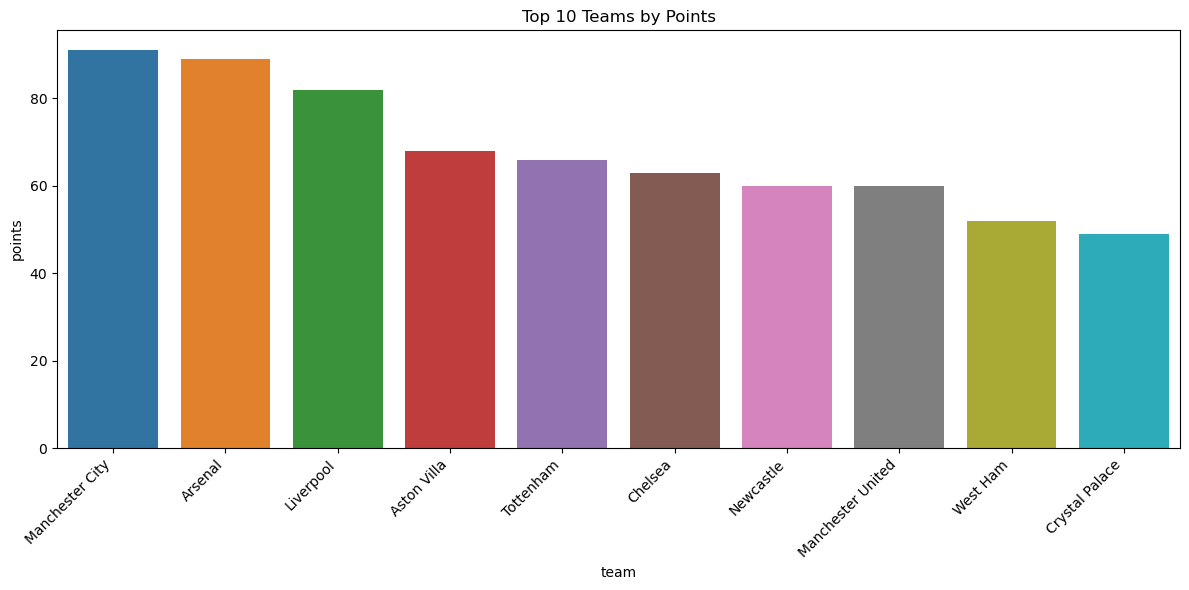

                team  points  played  won  drawn  lost
0    Manchester City      91      38   28      7     3
1            Arsenal      89      38   28      5     5
2          Liverpool      82      38   24     10     4
3        Aston Villa      68      38   20      8    10
4          Tottenham      66      38   20      6    12
5            Chelsea      63      38   18      9    11
6          Newcastle      60      38   18      6    14
7  Manchester United      60      38   18      6    14
8           West Ham      52      38   14     10    14
9     Crystal Palace      49      38   13     10    15


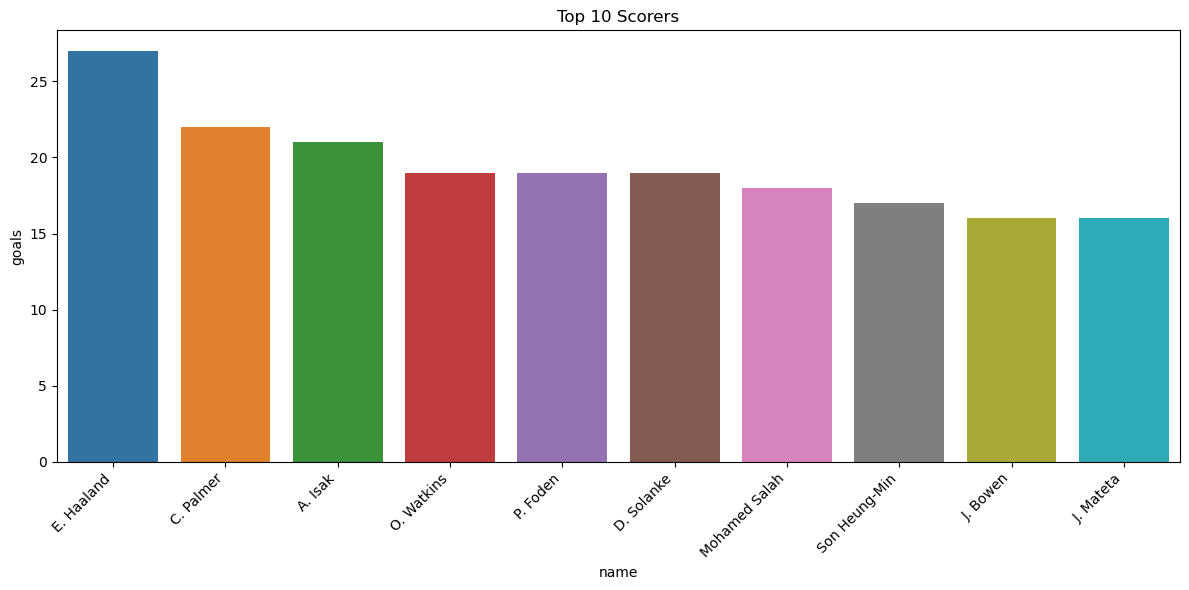

            name             team  goals  assists  played
0     E. Haaland  Manchester City     27        5      31
1      C. Palmer          Chelsea     22       11      33
2        A. Isak        Newcastle     21        2      30
3     O. Watkins      Aston Villa     19       13      37
4       P. Foden  Manchester City     19        8      35
5     D. Solanke      Bournemouth     19        3      38
6  Mohamed Salah        Liverpool     18       10      32
7  Son Heung-Min        Tottenham     17       10      35
8       J. Bowen         West Ham     16        6      34
9      J. Mateta   Crystal Palace     16        5      35

Building prediction model for Manchester United...

Model Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87   

In [52]:
def main():
    league_id = 39  # Premier League
    season = 2023
    team_id = 33  # 맨유로 예시 

    # 순위 데이터 가져오기 및 분석
    standings_data = get_league_standings(league_id, season)
    if standings_data:
        standings_df = parse_standings(standings_data)
        analyze_standings(standings_df)
    else:
        print("Failed to fetch standings data")

    # 득점 순위 데이터 가져오기 및 분석
    scorers_data = get_top_scorers(league_id, season)
    if scorers_data:
        scorers_df = parse_top_scorers(scorers_data)
        analyze_top_scorers(scorers_df)
    else:
        print("Failed to fetch top scorers data")

    # 승리 예측 모델 구축
    print("\nBuilding prediction model for Manchester United...")
    model, scaler = build_prediction_model(team_id, season)

    if model and scaler:
        # 예시: 홈경기에서 2-1로 이길 경우의 승리 확률 예측
        win_prob = predict_match_outcome(model, scaler, 1, 2, 1)
        print(f"\nPredicted win probability for a home game with 2-1 score: {win_prob:.2f}")

if __name__ == "__main__":
    main()
